## **1. Introduction**
`wavesolve` is a lightweight package which can solve for the scalar and vector eigenmodes of waveguides using the finite-element method (specifically, Galerkin's method - read more <a href = "finite_element_method_notes.pdf"> here</a>.) The general workflow for `wavesolve` is the following:

1. Define a waveguide cross-section, by defining refractive index values and material boundaries
2. Generate a finite element mesh for the waveguide
3. Solve the generalized eigenvector problem on the mesh, giving the guided modes.

To implement the above, `wavesolve` provides the following submodules:

1. `waveguide`: a set of classes which define waveguides and generate meshes.
2. `FEsolver`: a set of functions which solve for waveguide eigenmodes on finite element meshes.

**Section 2** goes over the `waveguide` submodule, while **Section 3** provides documentation for the `FEsolver` submodule.  **Section 4** includes examples involving photonic crystal fibers.


## **2. `waveguide` module**

The `waveguide` module lets you to model 2D waveguide cross-sections.

<a id='sec2.1'></a>
### **2.1 Defining waveguides**

In this section we discuss how to build waveguides from the bottom-up. In practice, users may only need to interact with the high-level `Waveguide` class covered in Section 2.1.2.

<a id='sec2.1.1'></a>
#### **2.1.1 `Prim2D` class**

The basic parent class that represents a refractive index geometry is a `Prim2D` (2D primitive). Each `Prim2D` stores a refractive index value and an array of $(x,y)$ points bounding the physical region which contains that index value. A `Prim2D` is initialized as

**`prim2D = waveguide.Prim2D(n,label,points)`**

**Arguments**

1.  `n` : the refractive index of the primitive. 

2. `label` : a string identifier to attach to the primitive (e.g. "core" or "cladding").

3. `points` (optional): an $N\times 2$ array of $(x,y)$ points corresponding to a material interface. The first and last point are automatically connected. Default is `None`, since `points` can also be generated with functional dependence, as mentioned next.  

To make specific types of geometries, users are encouraged to define subclasses that inherit from `Prim2D` and generate `points` according to specific rules. These subclasses should implement their own `make_points()` functions, which at minimum should take in some set of arguments (like radius, for a circle primitive) and return the corresponding point array. Subclasses should also implement the following function:

**`boundary_dist(x,y)`** : compute the minimum distance between the point $(x,y)$ and the primitive boundary, returning a negative value if the point is inside the boundary. 

See the `Circle`, `Ellipse`, and `Rectangle` classes for examples. 

More complicated primitives can be created through `waveguide.Prim2DUnion`, representing a list of intersecting primitives, and `waveguide.Prim2DArray`, representing a list of non-intersecting primitives.

> **Note:** `points` should always be ordered counterclockwise!

<a id='sec2.1.3'></a>
#### **2.1.2 `Waveguide` class**

A `Waveguide` stores a (potentially nested) list of `Prim2D`s, which we will call `prim2Dgroups`. The refractive index profile of each top-level element in `prim2Dgroups` is overwritten by the immediate next element. An element in `prim2Dgroups` can also be a list of `Prim2D` objects; in this case all elements in the sublist override the refractive index profile of the previous element.$^\dagger$ So, an optical fiber might store its primitives as `[cladding,core]`, where `cladding` and `core` are `Circle(Prim2D)` objects corresponding to the cladding and core regions; a multicore fiber could have the structure `[cladding,[core1,core2,...]]`. A `Waveguide` is initialized as 

**`wvg = Waveguide(prim2Dgroups)`**

**Arguments** 

1.  `prim2Dgroups` : the potentially nested list of 2D primitives mentioned above.

Like before, users are encouraged to define their own `Waveguide` subclasses, which initialize a set of `Prim2D` objects and arranges them as desired. The `Waveguide` class is mainly used to generate meshes, which can be tuned via `Waveguide` class attributes; see Section 2.2 for more details. For example `Waveguides`, check out the `CircularFiber`, `EllipticalFiber`, and various photonic-lantern-related classes.

$^\dagger$ `Prim2D` objects in the same sublist should never intersect. However, they can have different `label`s and refractive indices. If you want to model intersecting primitives, you should make a `Prim2DUnion`; see **Section 2.3** for an example.

Once the waveguide is initialized, you can get the refractive index dictionary of the waveguide, use **`Waveguide.assign_IOR()`**. 

To view meshes, the `Waveguide` class implements **`Waveguide.plot_mesh()`**:

**`Waveguide.plot_mesh()`**

**Optional arguments**
1. `mesh`: the mesh to plot. If `None`, one is generated using default values through `make_mesh()`.
2. `IOR_dict`: dictionary of refractive index values. If `None`, one is generated through `assign_IOR()`.

Another plotting method is **``Waveguide.plot_boundaries()``**, which plots all material boundaries in waveguide.

### **2.2 Mesh generation**

Mesh generation is primarily handled using

**`Waveguide.make_mesh(algo,order,adaptive):`**

**Optional Arguments**

1. `algo` : the mesh generation algorithm used by Gmsh. The default `6` is good starting point.
2. `order` : the order of the finite elements. Order `1` (linear triangle) and `2` (quadratic triangle) are implemented; default `2`.
3. `adaptive`: whether or not to refine mesh element sizes so that the mesh is most refined only at primitive boundaries; default `True`. 

When using the mode `adaptive=True`, a target mesh size is computed over the computation region as function of $(x,y)$. For a single `Prim2D` object, a target mesh size at a given $(x,y)$ point is computed as 

$$
{\rm target \, size} = d_0\left(1+ \dfrac{s \, d(x,y)}{d_0} \right)^p
$$
where $d_0$ is the "default" mesh size set by the resolution of the `Prim2D` boundary, $d(x,y)$ is the distance between the point $(x,y)$ and the primitive's boundary, and $s$ and $p$ are variables. The default values for both $s$ and $p$ are 1; higher values mean that mesh size will increase more rapidly away from the boundary. For multiple primitives, a target size is computed for each and the minimum size is taken. Then the target size is clipped between a minimum and maximum allowed value. This function is implemented in

`Waveguide.compute_mesh_size(x,y,_scale,_power,min_size,max_size)`

where the `_scale` and `_power` args correspond to $s$ and $p$. The parameter values for the adaptive scheme are set through the following `Waveguide` class attributes:

* `mesh_dist_scale` : $s$, the mesh boundary refinement linear distance scaling. Default `0.25`.
* `mesh_dist_power` : $p$, mesh boundary refinement power scaling. Default `1` (linear).
* `min_mesh_size` : minimum allowed mesh size, default `0.1`.
* `max_mesh_size` : maximum allowed mesh size, default `10`.

Users can also specify a target mesh size, and toggle boundary refinement on a per-primitive basis. This is done through the following `Prim2D` attributes: 

* `mesh_size` : target mesh size within the boundary of the primitive (otherwise the mesh size is set by the scheme described above.)
* `skip_refinement` : whether or not mesh refinement should be applied at the primitive boundary. The outer boundary of the entire mesh should have this set to `True`; default `False`.


### **2.3 Example: 3-port photonic lantern**
Below we use the `waveguide` module to make a 3-port photonic lantern, formed by tapering down a bundle of 3 single-mode fibers. The small end of such a device typically has a flower-shaped cladding that can be approximated by 3 overlapping circles (each corresponding to a fiber stock in the bundle).

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


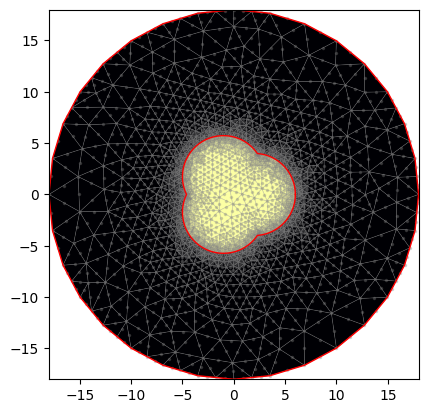

In [1]:
from wavesolve import waveguide
import numpy as np
import matplotlib.pyplot as plt

## params 
nclad = 1.444+5e-3
njack = 1.444

rclad = 4. # cladding radius
rjack = 18. # jacket (outermost) radius
res = 64 # resolution for boundary

rclad_offset = 2.

offsetsx = [1,np.cos(2*np.pi/3),np.cos(4*np.pi/3)]
offsetsy = [0,np.sin(2*np.pi/3),np.sin(4*np.pi/3)]
offsets = np.array([offsetsx,offsetsy]).T * rclad_offset

# make overlapping circular claddings
clads = []
for o in offsets:
    clad = waveguide.Circle(nclad,"cladding")
    clad.make_points(rclad,res,o)
    clads.append(clad)

# union
cladunion = waveguide.Prim2DUnion(clads,"cladding")
# make jacket
jacket = waveguide.Circle(njack,"jacket")
jacket.make_points(rjack,int(res/2))

# now assemble into waveguide
PL = waveguide.Waveguide([jacket,cladunion])

# mesh generation
mesh = PL.make_mesh()

# view
fig,ax = plt.subplots(1,1)
PL.plot_mesh(mesh,ax=ax) # mesh plot
PL.plot_boundaries(ax) # boundary plot

Prim2DUnion('cladding')


## **3. `FEsolver` module**

This module takes meshes generated by `waveguide` and solves the corresponding generalized eigenvalue problem to get the waveguide eigenmodes. It supports scalar mode solving on linear or quadratic triangular elements, and vector mode solving on linear triangular elements.

### **3.1. Scalar modes**

Scalar modesolving is primarily for low-index-contrast waveguides, where the Helmholtz equation is separable into two identical equations corresponding to the two linear polarizations.

#### 3.1.1. **Solving**

Given a finite element mesh, we can use the function `FEsolver.solve_waveguide()` to get the scalar eigenmodes. This function can handle both order 1 and order 2 (linear and quadratic triangle) meshes. The signature is as follows:

**`solve_waveguide(mesh,wl,IOR_dict,Nmax=6,target_neff=None)`**

**Arguments**

1. `mesh`: mesh object corresponding to waveguide geometry
2. `wl`: wavelength, defined in the same units as mesh point positions
3. `IOR_dict`: a dictionary assigning different named regions of the mesh different refractive index values
4. `Nmax`: return only the `Nmax` largest eigenvalue/eigenvector pairs; default 6.
5. `target_neff`: expected effective index of the mode you want to solve for; autocomputed if `None`.

**Returns**
1. `w`: array of eigenvalues, descending order
2. `v`: array of corresponding eigenvectors (waveguide modes)

To count the number of guided modes, use **``FEsolver.count_modes(w,wl,IOR_dict)``**, the args are the same as above.

#### 3.1.2. **Plotting**

To a scalar field, e.g. a scalar eigenmode (which is a row of the `v` matrix above), use

**`plot_scalar_field(mesh,field,show_mesh=False,ax=None,res=100,bounds=None)`**

**Arguments**
1.  `mesh`: finite element mesh
2.  `field`: an array (column vector) corresponding to an eigenmode
3.  `show_mesh`: set True to additionally plot the mesh geometry
4.  `ax`: optionally put the plot on a specific matplotlib axis
5.  `res`: grid resolution, make tuple to set xres and yres separately
6.  `bounds`: 4-element array `[xmin,xmax,ymin,ymax]`, setting plot boundary. If `None`, use the mesh boundary.

#### **3.1.3. Example - circular fiber**
In this example we generate a circular step-index fiber with the `waveguide` module. Then we generate an order 2 mesh and solve it using `solve_waveguide()`.

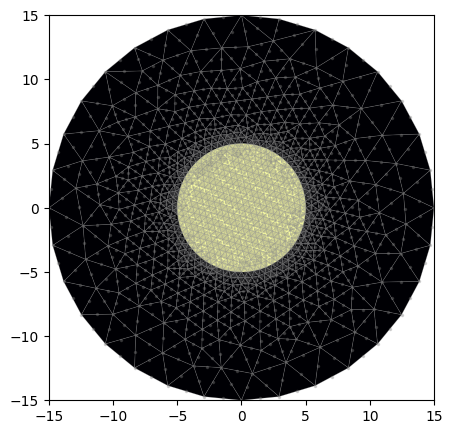

In [3]:
from wavesolve.FEsolver import solve_waveguide,plot_scalar_field,count_modes
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore = 5
rclad = 15
ncore = 1.444+8.8e-3
nclad = 1.444

# 3-mode fiber
circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,32,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()

mesh = circular_fiber.make_mesh()

# show the mesh - this plotting actually takes the bulk of the time
circular_fiber.plot_mesh(mesh)

Solving...

number of modes:  3


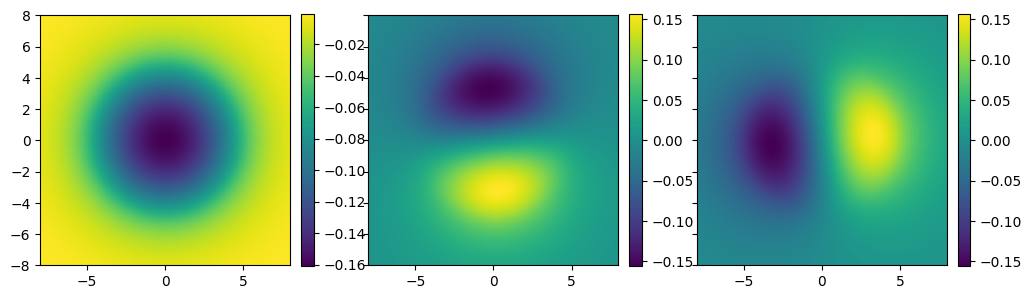

In [4]:
# solve for the first 10 modes
_w,_v = solve_waveguide(mesh,wl,IOR_dict,Nmax=10,solve_mode="sparse")

# there are only 3 guided modes
print("number of modes: ",count_modes(_w,wl,IOR_dict))

# plot the 3 guided modes
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_scalar_field(mesh,_v[i],ax=ax,bounds=(-8,8,-8,8))
plt.show()

We can also make and solve on an order 1 mesh. To do so, set `order=1` for the `make_mesh()` function.

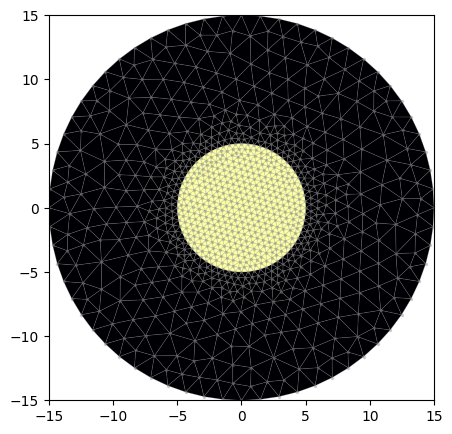

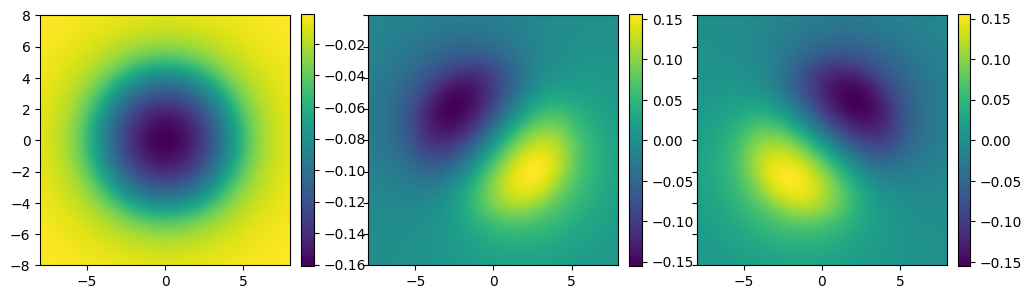

In [18]:
mesh_order1 = circular_fiber.make_mesh(order=1)
circular_fiber.plot_mesh(mesh_order1)
_w1,_v1 = solve_waveguide(mesh_order1,wl,IOR_dict,Nmax=10)

fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))
for i,ax in enumerate(axs):
    ax.set_aspect('equal')
    plot_scalar_field(mesh_order1,_v1[i],ax=ax,bounds=(-8,8,-8,8))
plt.show()

These are the LP01 and LP11 modes.

#### **3.1.4. Evaluating and interpolating mode fields**

The ``FEsolver`` module provides some functions for evaluating fields which are defined on finite-element meshes. To evaluate a field on a rectangular grid, we may use ``FEsolver.evaluate_grid()``. 

**`evaluate_grid(pointsx,pointsy,field,mesh)`**

**Arguments**

1. `pointsx` : 1D array of $x$ coordinates

2. `pointsx` : 1D array of $y$ coordinates

3. `field` : the electric field (e.g. an eigenmode) to be evaluated

4. `mesh` : the finite element mesh on which `field` is defined, assumed to be sorted.

This returns a 2D array, corresponding to `field` evaluated on the rectangular grid.

Note that to use any evaluation functions, the mesh data needs to be sorted first. You can do this explicitly via ``FEsolver.sort_mesh(mesh)``, but this step is also included in the solving functions `solve_waveguide` and `solve_waveguide_vec`.

In [7]:
import numpy as np
from wavesolve.FEsolver import evaluate_grid

xa = ya = np.linspace(-10,10,100) # make grid coordinate arrays, zoomed in a bit
_vgrid = evaluate_grid(xa,ya,_v[i],mesh)
print(_vgrid.shape)

(100, 100)


Pointwise evaluations can also be handled via ``FEsolver.evaluate(point,field,mesh)``, for example

In [8]:
from wavesolve.FEsolver import evaluate

print(evaluate(np.array([0.,0.]),_v[0],mesh)) # one point
print(evaluate(np.array([[0.,0.],[1.,1.]]),_v[0],mesh)) # multiple points

0.16091029228131778
[0.16091029 0.15052994]


#### **3.1.5 3-port PL mode solving**

For fun, let's return to the earlier 3-port PL and find the modes.

number of modes:  3


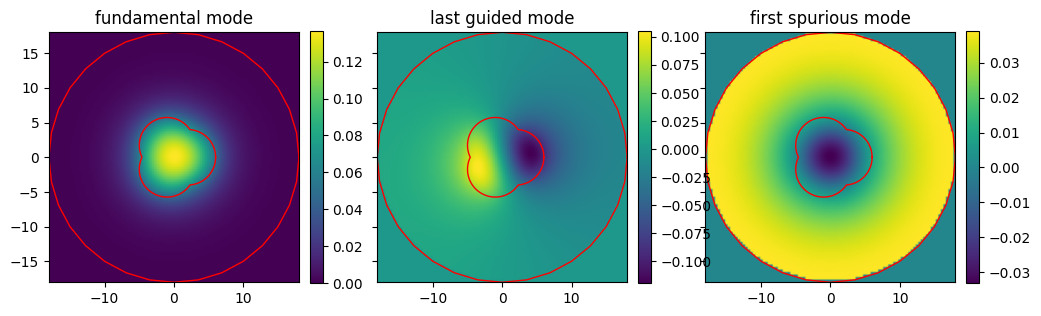

In [14]:
IOR_dict = PL.assign_IOR()
mesh = PL.make_mesh()

#not sure how many modes there will be, so we'll get the first 50
_w,_v = solve_waveguide(mesh,wl,IOR_dict,Nmax=50)

Nmodes = count_modes(_w,wl,IOR_dict)
print("number of modes: ",Nmodes)

fig,axs = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,8))

plot_scalar_field(mesh,_v[0],show_mesh=False,ax=axs[0])
plot_scalar_field(mesh,_v[Nmodes-1],show_mesh=False,ax=axs[1])
plot_scalar_field(mesh,_v[Nmodes],show_mesh=False,ax=axs[2])

for ax in axs:
    PL.plot_boundaries(ax) # show the waveguide boundary

axs[0].set_title("fundamental mode")
axs[1].set_title("last guided mode")
axs[2].set_title("first spurious mode")

plt.show()

For the above, I'm also showing the waveguide boundaries with ``Waveguide.plot_boundaries()``. The last plot shows a typical spurious/cladding mode, which is non-zero in the cladding.

### **3.2 Vector modes**

In `wavesolve`, vector modes are divided into transverse and longitudinal components. The longitudinal component is treated in the same way as a scalar mode, which has a defined value at every node position. In contrast, the transverse electric field is specified by assigning a value for the tangential electric field to every mesh edge (here "tangential" is with respect to the edge). This approach guarantees that the boundary conditions for Maxwell's equations are fulfilled. If $N_e$ is the number of mesh edges and $N_n$ is the number of nodes, a vector mode is an $N_e+N_n$ array whose first $N_e$ elements determine the transverse field and whose last $N_n$ components determine the longitudinal field.

> **Note:** ``wavesolve`` performs a change of variables to treat both the transverse and longitudinal field components as purely real, when physically they should be 90 degrees out of phase (i.e. the longitudinal field should be purely imaginary). See [*Lee et al. 1991*](https://ieeexplore.ieee.org/document/85399) for more details.

#### **3.2.1. Solving**

To solve for the vector modes, we can use `FEsolver.solve_waveguide_vec()`. The vectorial solver is implemented for linear triangle elements (`order=1`). The call signature is the same as the scalar `solve_waveguide()`. 

**`solve_waveguide_vec(mesh,wl,IOR_dict,Nmax=6,target_neff=None)`**

**Arguments**

1. `mesh`: mesh object corresponding to waveguide geometry
2. `wl`: wavelength, defined in the same units as mesh point positions
3. `IOR_dict`: a dictionary assigning different named regions of the mesh different refractive index values
5. `Nmax`: return only the `Nmax` largest eigenvalue/eigenvector pairs
6. `target_neff`: expected effective index of the mode you want to solve for; autocomputed if `None`.

**Returns**
1. `w`: array of eigenvalues, descending order
2. `v`: array of corresponding eigenvectors (waveguide modes)

The default solving mode is to transform the generalized eigenproblem $A x =\lambda B x$ is transformed to $Cx = \lambda x$ where $C$ solves $BC = A$ ; this system is solved with ``Pardiso.jl``.

To count the number of guided modes, we can again use ``FEsolver.count_modes(w,wl,IOR_dict)``. **HOWEVER**...

> **Warning**: 
> Identifying spurious vector modes turns out to be tricky. `count_modes` only works for **weakly guiding** waveguides! For high index contrast, you need to use the eye test, at least for now.


#### **3.2.2 Plotting**

To plot a vector eigenmode, use `plot_vector_field()`, which has the same signature as `plot_scalar_field()` but produces a quiver plot corresponding to the transverse component of the electric field, and optionally a scalar plot of the longitudinal field as well. Call signature:

**`plot_vector_field(mesh,field,show_mesh,ax,arrows,res,bounds)`**

**Arguments**

1. `mesh`: finite element mesh
2. `field`: a 1D array (column vector) corresponding to a vector-valued field (e.g. eigenmode) which encodes both transverse and longitudinal components
3. `show_mesh`: set True to additionally plot the mesh geometry
4. `ax`: optionally put the plots on a matplotlib axis. if one axis is given, only the transverse part is plotted. if (ax0,ax1) is given, the longitudinal component is also plotted. if None, axes are made for both.
5. `arrows` : whether or not to overplot field arrows
6. `res`: grid resolution, make tuple to set xres and yres separately
7. `bounds`: 4-element array [xmin,xmax,ymin,ymax], setting plot boundary.


#### **3.2.3 Example: vector modes of circular fiber**

Note that the fiber parameters are the same as in the earlier scalar solving example. Therefore, we should find 6 vector modes (3 LP modes $\times$ 2 polarizations).

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


  Activating project at `c:\Users\jon88\miniconda3\envs\astro\lib\site-packages\wavesolve\FEsolver`
Precompiling FEsolver...
   1912.0 ms  ✓ FEsolver


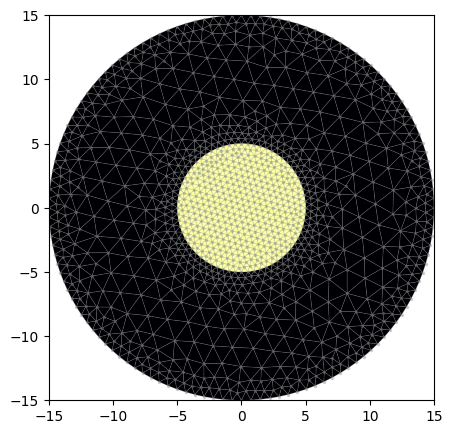

  1 dependency successfully precompiled in 2 seconds. 58 already precompiled.


In [1]:
from wavesolve.FEsolver import solve_waveguide_vec,plot_vector_field,count_modes
from wavesolve import waveguide
import matplotlib.pyplot as plt

rcore = 5
rclad = 15
ncore = 1.444+8.8e-3
nclad = 1.444

circular_fiber = waveguide.CircularFiber(rcore,rclad,ncore,nclad,64,128,core_mesh_size=0.5)

wl = 1.55 #um
IOR_dict = circular_fiber.assign_IOR()
mesh = circular_fiber.make_mesh(order=1)
circular_fiber.plot_mesh(mesh)

Solving...

number of modes:  6


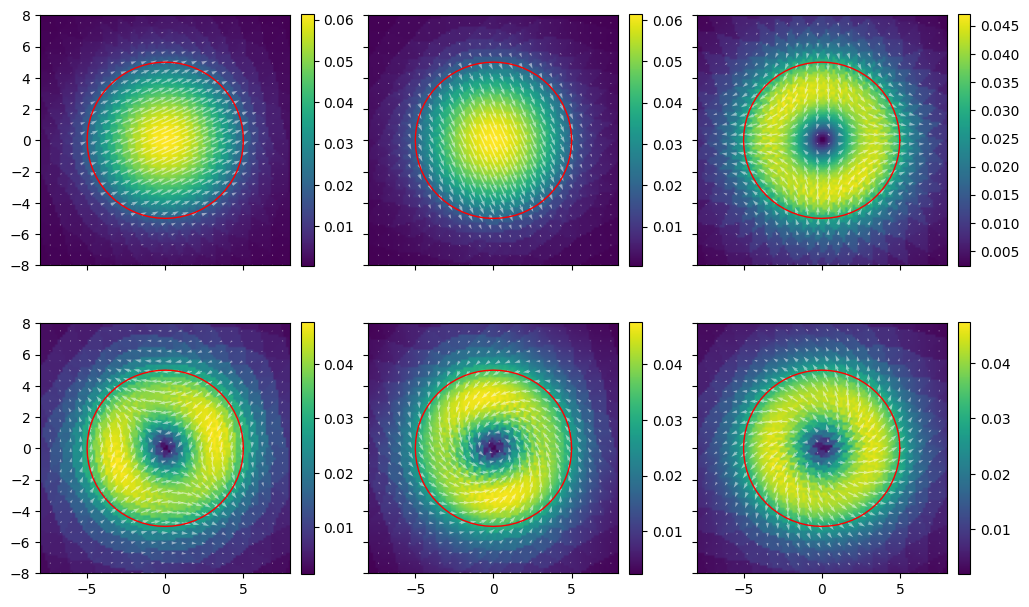

In [2]:
_w,_v = solve_waveguide_vec(mesh,wl,IOR_dict,Nmax=10,solve_mode="mixed")
print("number of modes: ",count_modes(_w,wl,IOR_dict))

fig,axs = plt.subplots(2,3,sharex=True,sharey=True,figsize=(12,8))
for i,ax in enumerate(axs.flatten()):
    ax.set_aspect('equal')
    plot_vector_field(mesh,_v[i],show_mesh=False,ax=ax,bounds=(-8,8,-8,8))
    circular_fiber.plot_boundaries(ax)
plt.subplots_adjust(hspace=0)
plt.show()

In [5]:
import time
start = time.time()
for i in range(10):
    _w,_v = solve_waveguide_vec(mesh,wl,IOR_dict,Nmax=10,solve_mode="mixed")

print(time.time()-start)

22.61077857017517


In [6]:
import time
start = time.time()
for i in range(10):
    _w,_v = solve_waveguide_vec(mesh,wl,IOR_dict,Nmax=10,solve_mode="dense")

print(time.time()-start)

22.677799224853516


The first two modes are the HE11 modes. The next four modes are linear combinations of the TE01, TM01, and HE21 modes, which have the same effective index. The rest are spurious (their effective index is lower than the cladding index).

We can also view the transverse and longitudinal components by using `plot_vector_field` without supplying a matplotlib axis.

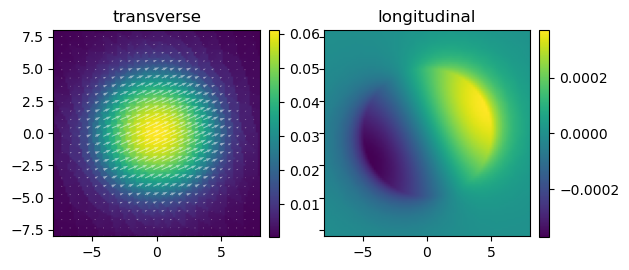

In [12]:
plot_vector_field(mesh,_v[0],show_mesh=False,bounds=(-8,8,-8,8))

The amplitude of the longitudinal field is quite small, which is a result of the weakly guiding nature of this waveguide. Note that physically, the longitudinal field should be purely imaginary (i.e. 90 degrees out of phase with the transverse field), but ``wavesolve`` -- and many other mode solvers -- apply a change of variables to treat both components as purely real.

#### 3.2.4 Elliptical core fiber
Elliptical core fibers use an asymmetric core to break the degeneracy between the two linear polarizations of the fundamental mode, via "form birefringence". Let's show this. First we'll design such a fiber. (Taking params from FiberLabs ZEF-2.2×5.5/125-N).

One of the interesting things about this example is that the accuracy of the computed birefringence in the fundamental mode seems particularly sensitive to the rate at which mesh elements are allowed to change in size; you can test this effect by changing ``Waveguide.mesh_dist_power`` and/or ``Waveguide.mesh_dist_scale``.

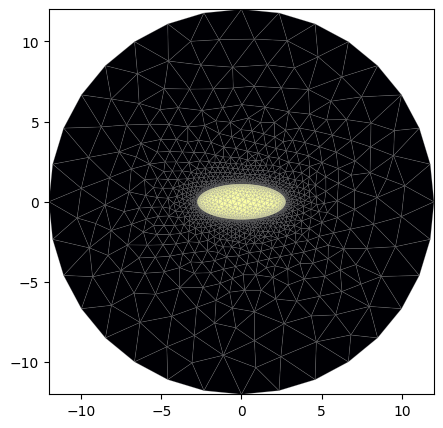

In [19]:
from wavesolve import waveguide

## params 
ncore = 1.512
nclad = 1.474
acore = 5.5/2 # extent of the elliptical core along the x axis
bcore = 2.2/2 # extent of the elliptical core along the y axis
rclad = 12. # cladding radius
core_res = 64 # resolution for core boundary
clad_res = 32

## make the fiber
core = waveguide.Ellipse(ncore,"core")
core.make_points(acore,bcore,core_res)
clad = waveguide.Circle(nclad,"cladding")
clad.make_points(rclad,clad_res)
fiber = waveguide.Waveguide([clad,core])

mesh = fiber.make_mesh(order=1)

fiber.plot_mesh(mesh,plot_points=False)

Now we'll solve.

number of modes:  4
birefringence:  (0.00029076476607658996+0j)


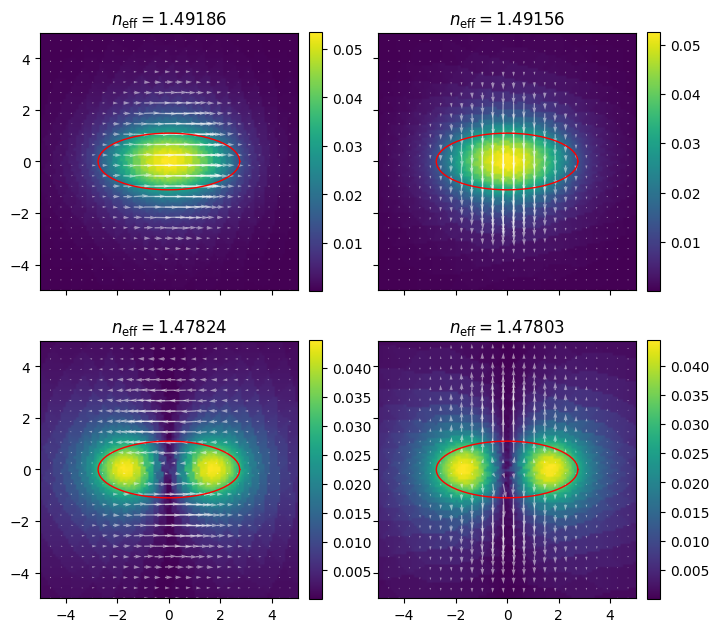

In [20]:
from wavesolve.FEsolver import count_modes,plot_vector_field,solve_waveguide_vec,get_eff_index
import matplotlib.pyplot as plt
import numpy as np

wl = 1.55
IOR_dict = fiber.assign_IOR()
_w,_v = solve_waveguide_vec(mesh,wl,IOR_dict,Nmax=10)
ne = get_eff_index(wl,_w)
print("number of modes: ",count_modes(_w,wl,IOR_dict))
print("birefringence: ",ne[0]-ne[1])
fig,axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
for i,ax in enumerate(axs.flatten()):
    ax.set_aspect('equal')
    ax.set_title(r"$n_{\rm eff}=$"+str(round(np.real(ne[i]),5)))
    plot_vector_field(mesh,_v[i],show_mesh=False,ax=ax,bounds=(-5,5,-5,5))
    fiber.plot_boundaries(ax) # show the core-cladding boundary
plt.subplots_adjust(hspace=0)
plt.show()

This fiber seems to be support four modes, but the latter two might be lossy since they extend further into the cladding. The birefringence is around $3\times 10^{-4}$, which seems reasonable (I could not find a spec on the manufacturer's site except for a comment that typical birefringence for these types of fibers is above $10^{-4}$).

## **4. Misc examples**

### **4.1 Index-guiding photonic crystal fiber**
A typical index-guiding photonic crystal fiber contains a cladding regularly perforated with air holes. A region of some characteric radius near the center of the fiber remains unperforated, and ultimately composes the "core" of the fiber. Below is an example. First, we'll make a mesh using the `PhotonicCrystalFiber` class. (When meshing adaptively, mesh generation takes longer for this structure because distances need to be every waveguide boundary.)

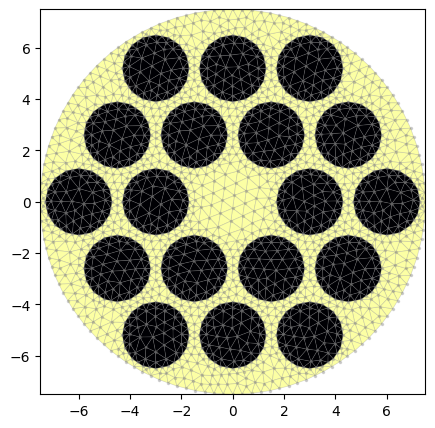

In [6]:
from wavesolve.waveguide import PhotonicCrystalFiber

hole_radius = 1.3
clad_radius = 7.5
hole_separation = 3.
nclad = 1.444
hole_res = 16
clad_res = 64
wl = 1.55

PCF = PhotonicCrystalFiber(hole_radius,clad_radius,nclad,hole_separation,hole_res,clad_res,hole_mesh_size=1.0,clad_mesh_size=0.5)
m = PCF.make_mesh(order=1)
PCF.plot_mesh(m)

Then, we'll use the vector solver to get the modes. This particular arrangement only has 2 guided modes; note that ``count_modes()`` will not measure this correctly since this waveguide has high index contrast.

In [8]:
from wavesolve.FEsolver import solve_waveguide_vec

IOR_dict = PCF.assign_IOR()
w,v = solve_waveguide_vec(m,wl,IOR_dict,Nmax=2)

Next, we can plot the vector-valued field with ``FEsolver.plot_vector_field``. Note that the color scale on the transverse plot corresponds to the modulus of the vector field.

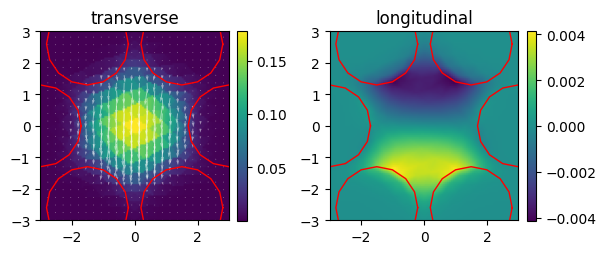

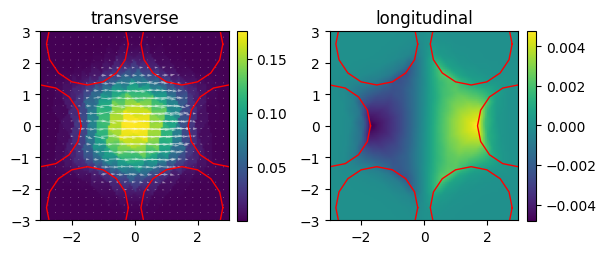

In [9]:
from wavesolve.FEsolver import plot_vector_field
import matplotlib.pyplot as plt

for i in [0,1]:
    fig,axs = plt.subplots(1,2)
    plot_vector_field(m,v[i],ax=axs,arrows=True,bounds=(-3,3,-3,3))
    for ax in axs:
        PCF.plot_boundaries(ax)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

Interestingly, the triangle boundaries of the mesh are visible. I think this is because the vector FEM approach we're using is edge-based, assigning a tangential component to the electric field along the edge of every triangle. Doing so ensures tangential continuity everywhere, but does not enforce normal (i.e. edge-perpendicular) continuity, so the modulus of the vector field is overall discontinuous. 

We can also evaluate the vector-valued tangential component of the electric field over a rectangular grid, using the same ``evaluate_grid()`` function as before. When applied to vectorial electric fields, it returns two components, corresponding to the transverse and longitudinal electric field, respectively. 

In [18]:
from wavesolve.FEsolver import evaluate_grid
import numpy as np

xa = ya = np.linspace(-2,2,100)
xg,yg = np.meshgrid(xa,ya)
vt,vz = evaluate_grid(xa,ya,v[0],m)
print(vt.shape)
print(vz.shape)

(100, 100, 2)
(100, 100)


Like in the scalar case, we can also use ``FEsolver.evaluate`` to perform pointwise or arraywise evaluations of a vectorial field.

In [19]:
from wavesolve.FEsolver import evaluate

print(evaluate(np.array([0.,0.]),v[0],m)) # one point
print(evaluate(np.array([[0.,0.],[1.,1.]]),v[0],m)) # multiple points

(array([-0.00499952+0.j, -0.17761584+0.j]), array(1.75464736e-07+0.j))
(array([[-0.00499952+0.j, -0.17761584+0.j],
       [ 0.0008062 +0.j, -0.08860757+0.j]]), array([ 1.75464736e-07+0.j, -2.98025114e-03+0.j]))


### **4.2 Hollow core photonic crystal fiber**
In contrast with index-guiding photonic crystal fibers, hollow core fibers guide light in a region that is typically of lower index than the waveguide material. In this case, guidance is provided by the so-called photonic bandgap, which is analogous the electronic gap between Brillouin zones in crystals. Such modes are trickier to model because they have lower effective index, and might be hard to distinguish from cladding modes. In these cases, you may have to search for modes by specifying a target effective index for the guided mode.

Below is an example. First we'll make the mesh.

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


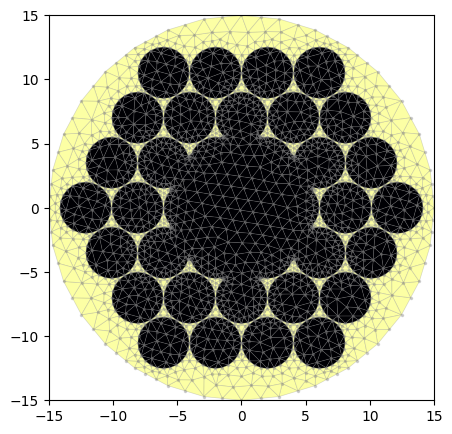

In [1]:
from wavesolve.waveguide import PhotonicBandgapFiber
import numpy as np

# these specs are loosely based off the images I found of NKT hollow core fibers.
void_radius = 11.5/2
hole_radius = 2.
clad_radius = 15.
nclad = 1.444
hole_separation = 4.05

hollow_PCF = PhotonicBandgapFiber(void_radius,hole_radius,clad_radius,nclad,hole_separation,24,32,hole_mesh_size=1.,clad_mesh_size=2.)
m = hollow_PCF.make_mesh(order=1)
hollow_PCF.plot_mesh(m)

Next, let's solve. The voids in this fiber have index 1, so I will search for modes with the largest indices at and below 1. ``FEsolver.count_modes()`` will not work here!

  Activating project at `c:\Users\jon88\miniconda3\envs\astro\lib\site-packages\wavesolve\FEsolver`


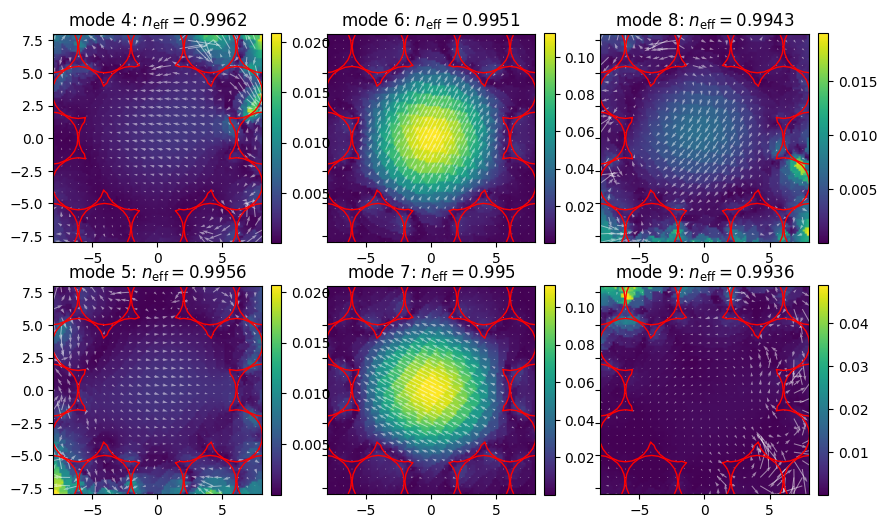

In [2]:
from wavesolve.FEsolver import get_eff_index,plot_vector_field,solve_waveguide_vec
import matplotlib.pyplot as plt
import numpy as np

IOR_dict = hollow_PCF.assign_IOR()
wl = 1.65

w,v = solve_waveguide_vec(m,wl,IOR_dict,target_neff=1.0,Nmax=10)
ne = get_eff_index(wl,w)

fig,axs = plt.subplots(2,3,sharey=True,figsize=(10,6))
for j,ax in enumerate(axs.T.flatten()):
    i = j+3
    plot_vector_field(m,v[i],ax=ax,bounds=(-8,8,-8,8))
    hollow_PCF.plot_boundaries(ax)
    ax.set_title("mode "+str(i+1)+r": $n_{\rm eff}=$"+str(round(np.real(ne[i]),4)))

plt.show()

After solving for the first 8 modes, I find that modes 5 and 6 are physical, with effective index $\approx 0.995$.

### **4.3 Known issues**

Below are some current issues in the code.

1. Mesh generation takes a while. The main issue is scaling: as the complexity of the waveguide goes up, the number of boundaries goes up, and it becomes more expensive to determine the distance to the nearest waveguide boundary. The meshing code is also in Python.
2. The doc sucks. I'll make a web doc soon ...
3. The eigensolver (particularly for vector modes) probably can be sped up, I haven't looked too much into it yet.

### Strip-loaded directional coupler

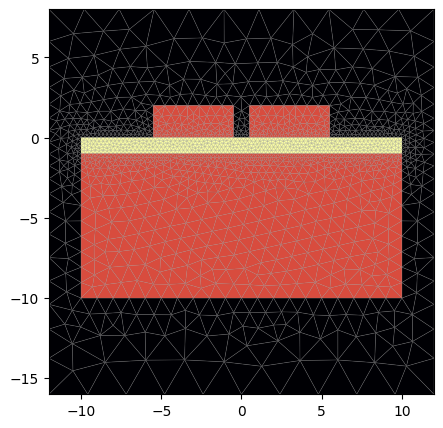

In [58]:
from wavesolve.waveguide import Rectangle,Waveguide

airclad = Rectangle(1.,"air")
airclad.make_points(-12,12,-16,8)

strip1 = Rectangle(1.45,"strip1")
strip1.make_points(-5.5,-0.5,0,2)

strip2 = Rectangle(1.45,"strip2")
strip2.make_points(0.5,5.5,0,2)

corelayer = Rectangle(1.77,"corelayer")
corelayer.make_points(-10,10,-1,0)

clad = Rectangle(1.45,"clad")
clad.make_points(-10,10,-10,-1)

strip1.mesh_size = 1.0
strip2.mesh_size = 1.0
clad.mesh_size = 1.0
corelayer.mesh_size = 0.25

wvg = Waveguide([airclad,[strip1,strip2,corelayer,clad]] )
m = wvg.make_mesh(order=1)

wvg.plot_mesh(m,plot_points=False)

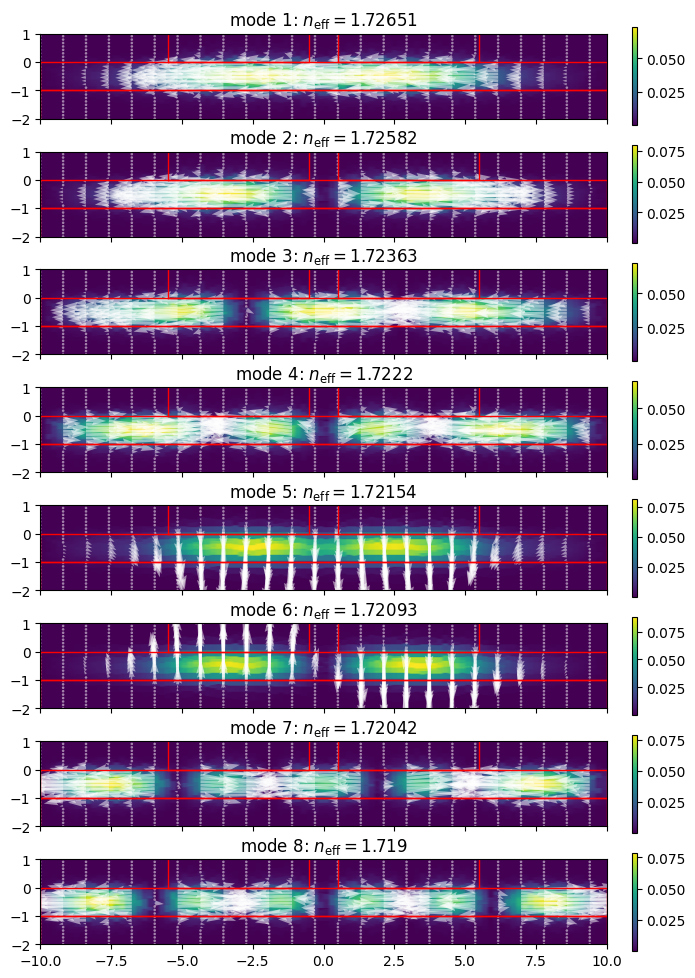

In [62]:
from wavesolve.FEsolver import solve_waveguide_vec,plot_vector_field,get_eff_index
import matplotlib.pyplot as plt

wl = 1.
IOR_dict = wvg.assign_IOR()

w,v = solve_waveguide_vec(m,wl,IOR_dict,Nmax = 8)

ne = get_eff_index(wl,w)

fig,axs = plt.subplots(8,1,sharex=True,sharey=True,figsize=(8,12))
for i,ax in enumerate(axs.flatten()):
    ax.set_title("mode "+str(i+1)+r": $n_{\rm eff}=$"+str(round(np.real(ne[i]),5)))
    plot_vector_field(m,v[i],ax=axs.flatten()[i],bounds=(-10,10,-2,1))
    wvg.plot_boundaries(ax)
plt.show()